##### Social Media Analytics
### Introduction to Text Mining
## Topic Modeling
(c) Nuno Antonio 2019-2021

### Initial setup

In [1]:
# Import packages
import csv
import pandas as pd
import numpy as np
import nltk 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import gensim         
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [3]:
# Just because of versions on my computer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/nunoantonio/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Load dataset
dtypes = {'RevID':'category','Source':'category','HotelID':'category',
  'HotelType':'category','HotelStars':'category','ObsDateGlobalRating':'float64',
  'Language':'category','RevUserName':'category','RevUserLocation':'category','RevOverallRating':'float64'}
ds = pd.DataFrame(pd.read_csv("HotelOnlineReviews.txt",sep="|", 
  error_bad_lines=False, dtype=dtypes, decimal=','))

b'Skipping line 12799: expected 21 fields, saw 23\n'
b'Skipping line 37247: expected 21 fields, saw 22\n'


In [5]:
# Drop non-English reviews
ds = ds.drop(ds[ds.Language!='English'].index)

### Functions

In [6]:
# Text preprocessing
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True):
    cleanedText = []
    for x in (rawText[:]): 
        
        # Remove HTML
        if removeHTML:
            procText = BeautifulSoup(x,'html.parser').get_text()

         # Remove punctuation and other special characters
        if len(charsToRemove)>0:
            procText = re.sub(charsToRemove,' ',procText)

        # Remove numbers
        if removeNumbers:
            procText = re.sub(r'\d+',' ',procText)

        # Remove line breaks
        if removeLineBreaks:
            procText = procText.replace('\n',' ').replace('\r', '')

        # Remove special characters
        if len(specialCharsToRemove)>0:
            procText = re.sub(specialCharsToRemove,' ',procText)

        # Normalize to lower case
        if convertToLower:
            procText = procText.lower() 

        # Replace multiple consecutive spaces with just one space
        if removeConsecutiveSpaces:
            procText = re.sub(' +', ' ', procText)

        # If there is a text, add it to the clean text         
        if procText != '':
            cleanedText.append(procText)
    return cleanedText

In [7]:
# Tokenize texts
def tokenize_words(texts):
    words_new = []
    for w in (texts[:]):
        w_token = word_tokenize(w)
        if w_token != '':
            words_new.append(w_token)
    return words_new

In [8]:
# Function to recreate text from words
def recreateText(words):
    text_new = []
    for w in (words[:]):
        temp_str = (' ').join(w)
        text_new.append(temp_str)
    return text_new

In [9]:
# Function to remove stop words
def removeStopWords(texts, stop_words):
  procText = []
  for t in (texts[:]):
    cleaned_text = [w for w in t[:] if not w in stop_words]
    procText.append(cleaned_text)
  return procText

In [10]:
# Function to lemmatize words
def lemmatize(words):
  lemmatizer = WordNetLemmatizer()
  procText = []
  for w in (words[:]):
    lemmatized_word = [lemmatizer.lemmatize(x) for x in (w[:])]
    procText.append(lemmatized_word)
  return procText

### Analysis

In [13]:
# Preprocess text 
processedReviews =  pd.DataFrame(data=textPreProcess(ds.RevDescription), index=ds.RevID, columns=['PreProcessedText']) 

In [14]:
# Tokekinze words
processedReviews['Words'] =  tokenize_words(processedReviews['PreProcessedText'])

# Remove stopwords
stop_words = set(stopwords.words('english'))
processedReviews['WordsCleaned'] = removeStopWords(processedReviews['Words'], stop_words)

# Remove all reviews with no words
processedReviews = processedReviews[processedReviews['WordsCleaned'].str.len()>0]

# Lemmative words
processedReviews['WordsLemmatized'] = lemmatize(processedReviews['WordsCleaned'])

In [15]:
# Create dictionary (needed for LDA)
id2word = corpora.Dictionary(processedReviews['WordsLemmatized'])

In [16]:
# Create corpus
corpus = processedReviews['WordsLemmatized']

In [17]:
# Create TDM (Frequency)
tdm = [id2word.doc2bow(text) for text in corpus]

In [18]:
# Build LDA model (can take from 2 to 10 minutes depending on the computer)
lda_model = gensim.models.ldamodel.LdaModel(corpus=tdm,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# Print the keywords in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[tdm]
# Interpretation: Topic 0 is represented as 0.055"walking" + 0.054"garden" + ...

[(0, '0.055*"walking" + 0.054*"garden" + 0.052*"old" + 0.048*"local" + 0.042*"distance" + 0.039*"look" + 0.037*"within" + 0.037*"square" + 0.025*"maintained" + 0.021*"tourist"'), (1, '0.093*"room" + 0.052*"hotel" + 0.039*"staff" + 0.034*"good" + 0.030*"breakfast" + 0.028*"great" + 0.023*"view" + 0.022*"tip" + 0.021*"restaurant" + 0.020*"nice"'), (2, '0.055*"day" + 0.039*"bed" + 0.038*"also" + 0.023*"even" + 0.022*"quiet" + 0.020*"large" + 0.017*"however" + 0.014*"water" + 0.014*"though" + 0.012*"hot"'), (3, '0.053*"night" + 0.047*"stayed" + 0.045*"time" + 0.026*"first" + 0.025*"much" + 0.023*"week" + 0.023*"star" + 0.018*"top" + 0.017*"found" + 0.017*"thing"'), (4, '0.080*"book" + 0.071*"bedroom" + 0.060*"fridge" + 0.058*"nearby" + 0.044*"lounge" + 0.038*"expected" + 0.035*"equipped" + 0.033*"design" + 0.030*"appointed" + 0.024*"pillow"'), (5, '0.067*"hotel" + 0.035*"n\'t" + 0.035*"would" + 0.027*"stay" + 0.023*"walk" + 0.022*"u" + 0.020*"get" + 0.019*"lisbon" + 0.018*"back" + 0.015*"g

In [20]:
# Visualize the topics (can take some mintues to run)
vis = pyLDAvis.gensim.prepare(lda_model, tdm, id2word)
pyLDAvis.show(vis)
#pyLDAvis.enable_notebook() # Remove remarks to see in notebook instead of the browser


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]
127.0.0.1 - - [19/Jan/2021 17:31:02] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 17:31:02] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 17:31:02] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 17:31:02] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2021 17:31:02] code 404, message Not Found
127.0.0.1 - - [19/Jan/2021 17:31:02] "GET /favicon.ico HTTP/1.1" 404 -

stopping Server...


### Evaluation of topic models
Good description at: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(tdm))  # lower value is better (some liteture do not recommend the use of this measure)


Perplexity:  -7.669531824398812


In [23]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3050963135236645


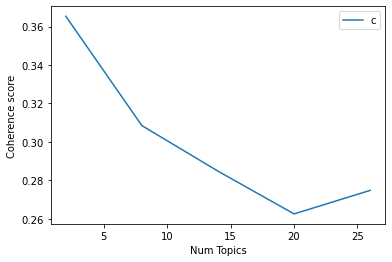

In [24]:
# HOW TO SELECT K (based on https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# ATTENTION!!!! Can take a LONG time to run.
lowerBound = 2
upperBound = 30
step = 6
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=tdm, texts=corpus, start=lowerBound, limit=upperBound, step= step)

# Show graph
x = range(lowerBound, upperBound, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# The coherence score is decreasing. A higher value should be chosen, because as K increases the probability of having repeated keywords increases.
# ...So, in this case we may choose 8, as there is an inflaction at K=8